## A Mathematical Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi and supported by Tohoku University in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [ ]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import fiona
from functools import reduce
from scipy.optimize import linprog
from scipy.sparse import csr_matrix

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

if not os.path.exists("temp/"):
    os.makedirs("temp/")


/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


'1.2.1'

### How do we represent road networks and GPS sequences computationally?

First, we download from OpenStreetMaps a street map for a section of Sendai, JP-- particularly, the area around Tohoku University. However, OSMnx by default does not track directionality of roads-- this is an important factor when map matching, so we use a script created by cyang-kth for their fmm program which saves this information.

<AxesSubplot:>

<AxesSubplot:>

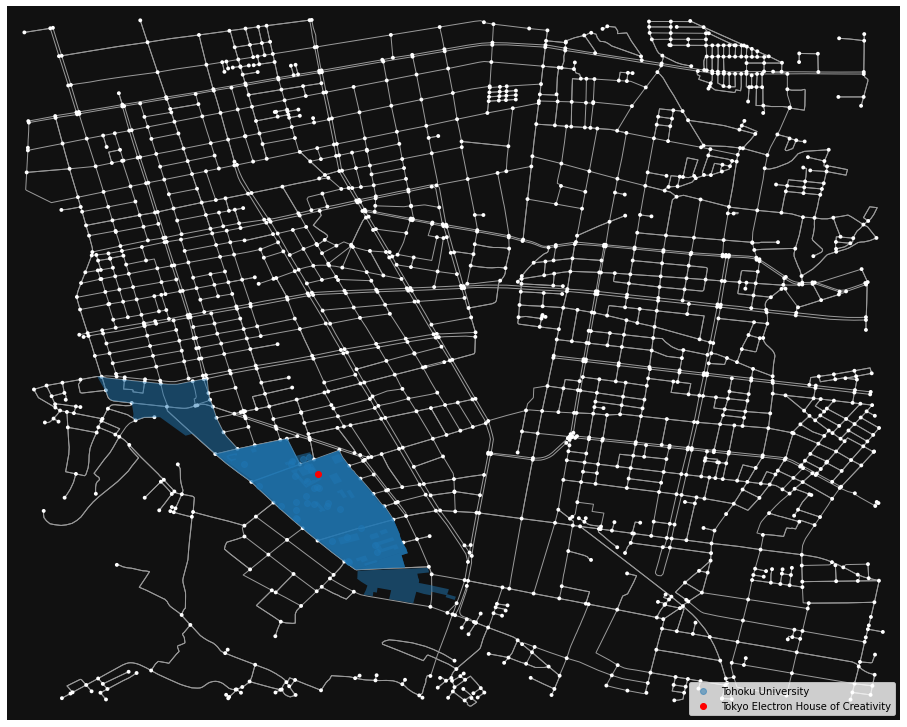

In [ ]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.legend(handles=[ax.collections[4],ax.collections[5]],
          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
          loc = 'lower right')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects geometrically, we will need to convert this to `GeoDataFrame`. 

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(bignetwork)
#gdf_edges.dtypes
gdf_edges = gdf_edges.reset_index([0,1,2])
gdf_edges = gdf_edges.set_index('osmid')
gdf_nodes[['geometry']].head()

,geometry
osmid,
244879417,POINT (140.87168 38.26613)
244879418,POINT (140.87520 38.26010)
301789611,POINT (140.87349 38.25607)
301789618,POINT (140.87595 38.25510)
301789634,POINT (140.87949 38.25282)


In [ ]:
gdf_edges[[ 'oneway', 'name', 'maxspeed', 'length', 'geometry']].head()

,oneway,name,maxspeed,length,geometry
osmid,,,,,
218028552,True,定禅寺通,60,17.586,"LINESTRING (140.87168 38.26613, 140.87148 38.2..."
461330966,True,東二番丁通,60,66.732,"LINESTRING (140.87168 38.26613, 140.87178 38.2..."
30999231,True,青葉通,NaN,15.304,"LINESTRING (140.87520 38.26010, 140.87503 38.2..."
899682371,True,東二番丁通,60,94.102,"LINESTRING (140.87520 38.26010, 140.87564 38.2..."
837910375,False,NaN,NaN,11.727,"LINESTRING (140.87349 38.25607, 140.87347 38.2..."


Now let's look at the GPS data from a day walking around Sendai.

In [ ]:
## We have some preprocessing to do first.

# Read the gpx directly
tripdata_nodes = gpd.read_file('7-15-2022.gpx', layer = 'track_points')
    
# Read the IMU data directly
with open('imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


Now let's fuse!

In [ ]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

<AxesSubplot:>

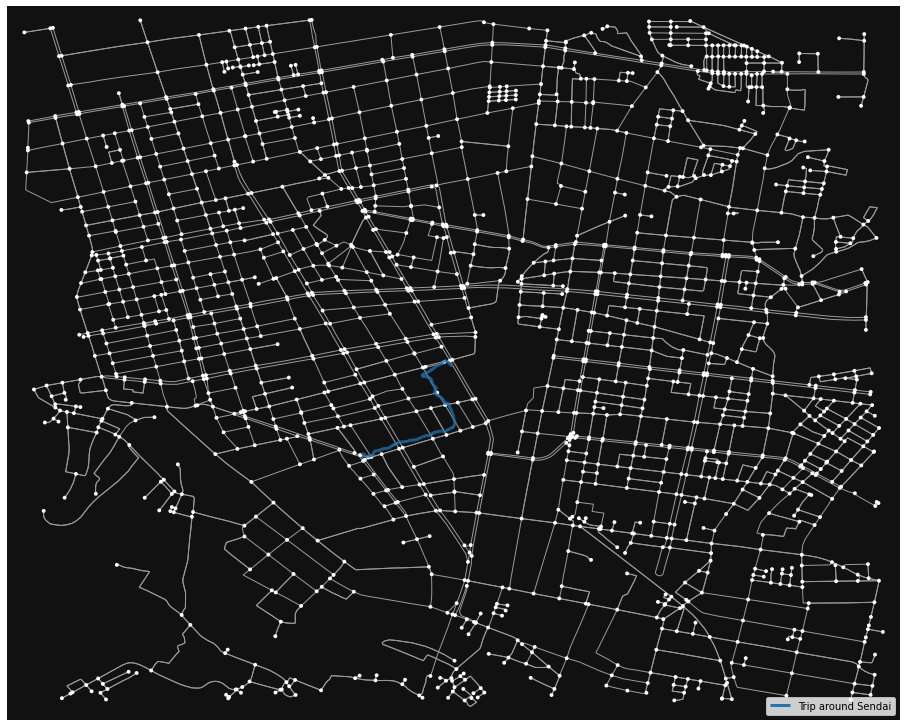

In [ ]:
fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False, close=False)
#tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax, linewidth=3)
ax.legend(handles=[ax.collections[2]],labels=['Trip around Sendai'], loc = 'lower right')

Let's zoom in a bit.

<AxesSubplot:>

(645, 6)


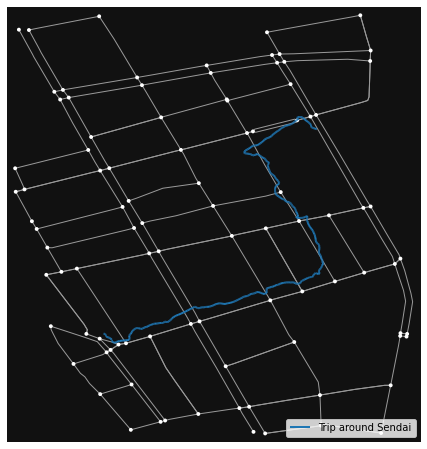

In [ ]:

smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(8,8), show=False, close=False)
tripdata_edges.plot(ax=ax, linewidth=2)
#tripdata_nodes.plot(ax=ax, markersize=1) # Don't really need to plot this, there's so many nodes that it looks identical to the edges
print(tripdata_nodes.shape)
ax.legend(handles=[ax.collections[2]],labels=['Trip around Sendai'], loc = 'lower right')

Now we will run this information through FMM.

In [ ]:
%%time

#from algorithms import fmm_bin # FMM broke AGAIN. Not fixing it this time.
#from fmm import FastMapMatchConfig
### Define map matching configurations

k = 16
radius = 0.003
gps_error = 0.0005

# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

#fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None



#fmm_sim = fmm_bin.FMM(cfg = fmm_config)

#fmm_sim.run(tripdata_edges)

# now restore stdout function
#sys.stdout = sys.__stdout__

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [ ]:

#mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = fmm_sim.results, fs = (16,16))
#plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','FMM Predicted Route'], loc = 'lower right')
#plt.gca().set_title('FMM Prediction')

This is pretty bad. The issue is that FMM (and other Hidden Markov Model approaches) do not perform well with an overabundance of data. Even small deviations with lots of datapoints dominate, and the algorithm tries to match it to roads it shouldn't.

This is where a geometric method performs better. If we work with nodes, these small deviations do not affect the loss much on average, so they are effectively ignored. If we work with a polyline, then the amount of nodes becomes entirely irrelevant, and so geometric methods are far more flexible when datapoint quantity may vary.

In [ ]:
from algorithms import metric_mm

### Define map matching configurations

## Least squares functions
ls_ri = lambda distarray: np.square(distarray) # The function applied directly to the distances from the candidate route to the k-NN GPS coords
ls_ro = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate' over the distances, and if we need to do anything else, we do it
ls_gi = lambda distarray: np.square(distarray) # The function applied directly to the distances from the GPS coords to the k-NN candidate route nodes
ls_go = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray))
##

## Inverse squares function ('Electrical method')
eps = 0.01
is_ri = lambda distarray: np.power(np.square(distarray) + eps, -1) # We need eps to prevent singularities, i.e. r = 0
is_ro = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray)) # We sum, and then multiply by -1 to turn the minimizing process into a maximizing process
is_gi = lambda distarray: np.power(np.square(distarray) + eps, -1)
is_go = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray))
##

def wrapper_f(ri, ro, gi, go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

ls_loss_function = wrapper_f(ls_ri, ls_ro, ls_gi, ls_go)
is_loss_function = wrapper_f(is_ri, is_ro, is_gi, is_go)

def wasserstein(routeloss, gpsloss):#gpsloss,n,m
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    # n is the number of points along the trajectory
    # m is the number of points on the candidate route
#    print(gpsloss.shape)
    n = gpsloss.shape[0]
    m = gpsloss.shape[1]
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    #Create equality constraints
    b = [1/n for i in range(0,n)]+ [1/m for i in range(0,m)]
    row1 = [i for i in range(0,n) for j in range(0,m)]
    row2 = [n+j for j in range (0,m) for i in range(0,n)]
    row = np.append(np.matrix.flatten(np.array(row1)),np.matrix.flatten(np.array(row2)))
    col1 = [list(range(0,n*m))]
    col2 =  [j+m*k for j in range(0,m) for k in range(0,n)]
    col = np.append(np.matrix.flatten(np.array(col1)),np.matrix.flatten(np.array(col2)))
    data = np.ones(n*m*2)
    A = csr_matrix((data, (row, col)),shape = (n+m, n*m)).toarray()
    A = A[:-1]
    b = b[:-1]
    #solve the linear program
    res = linprog(np.matrix.flatten(gpsloss),None, None,A,b)
    #return the function value, i.e. the wasserstein distance
    loss = res.fun
    return loss

In [ ]:
sim2 = metric_mm.Sim(ls_ri, ls_ro, ls_gi, ls_go, wrapper_f) # Least squares metric-based
sim3 = metric_mm.Sim(loss_function = is_loss_function)
sim4 = metric_mm.Sim(loss_function = wasserstein)

Before we use the simulators, we will do some preprocessing steps first. While the simulators have a built-in pre-processing stage, it is still better to compute candidate routes separately and then give it to the simulator. This is because we can choose our parameters for candidate routes better than the assumed defaults. This will also cut down on the pre-processing computation time as we can reuse the candidate routes with multiple simulators.

In [ ]:
%%time

print('Preprocessing Candidate Routes')

qry_pts = [y for sublist in [x.coords[:] for x in gdf_edges['geometry']] for y in sublist]            
source_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[0].x, tripdata_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
source_index = source_index[0][0]
target_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[-1].x, tripdata_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
target_index = target_index[0][0]

source = Point(qry_pts[source_index])
target = Point(qry_pts[target_index])

candidates = mm_utils.get_nearest_edges(tripdata_nodes, gdf_edges, k_neighbors=8, r = 0.01) # If r is too large it will run slow, as getting nearest edges is computationally difficult
    # I recommend starting with small values that yield less than k k_neighbors, and slowly increase from there
all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
candidate_routes, _ = mm_utils.dijkstra(source, target, all_candidate_edges, one_way = False)
# The one_way = False parameter is VERY important here.
# Road networks are given as collections of one-way streets.
# In Sendai, many small roads are one-way, and so the algorithm will assume you cannot traverse them in reverse
# In our case though, we are walking, so we can ignore one-way streets
# If you do not include this parameter, the route taken is not considered valid, and so is not considered at all.

Preprocessing Candidate Routes
CPU times: user 56.8 s, sys: 74.2 ms, total: 56.8 s
Wall time: 56.9 s


In [ ]:
%%time

print('Least Squares Runtime')

sim2.preprocessing(tripdata_edges, candidate_routes = candidate_routes, n = 1)
sim2_results = sim2.run(k1 = 10, k2 = 10, return_results = True)[0]


Least Squares Runtime
CPU times: user 15.9 s, sys: 150 ms, total: 16.1 s
Wall time: 16.1 s


In [ ]:
%%time

print('Inverse Squares Runtime')

sim3.preprocessing(tripdata_edges, candidate_routes = candidate_routes, n = 1)
sim3_results = sim3.run(k1 = -1, k2 = -1, return_results = True)[0]


Inverse Squares Runtime
CPU times: user 27.1 s, sys: 357 ms, total: 27.4 s
Wall time: 27.4 s


In [16]:
%%time

print('Wasserstein Runtime')
loss = []
sim4.preprocessing(tripdata_edges, candidate_routes = candidate_routes,n=1,m=2)
sim4_results = sim4.run(k1 = 0, k2 = -1, return_results = True)[0]



Wasserstein Runtime
CPU times: user 4h 3min 8s, sys: 22min 11s, total: 4h 25min 20s
Wall time: 3h 59min 4s


Text(0.5, 1.0, 'Least Squares Prediction')

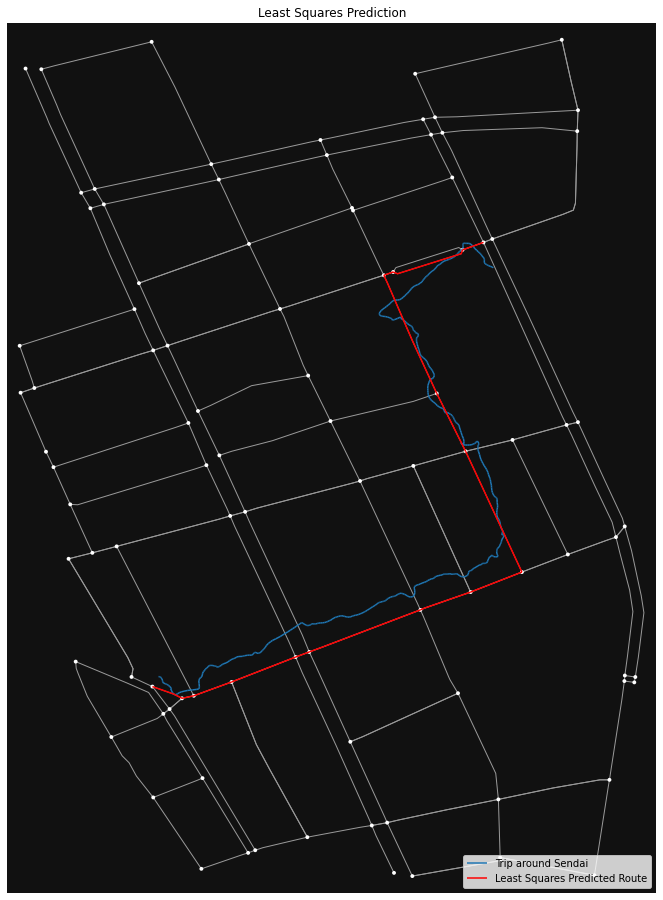

In [17]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim2_results, fs = (16,16))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Least Squares Predicted Route'], loc = 'lower right')
plt.gca().set_title('Least Squares Prediction')

Text(0.5, 1.0, 'Electric Method Prediction')

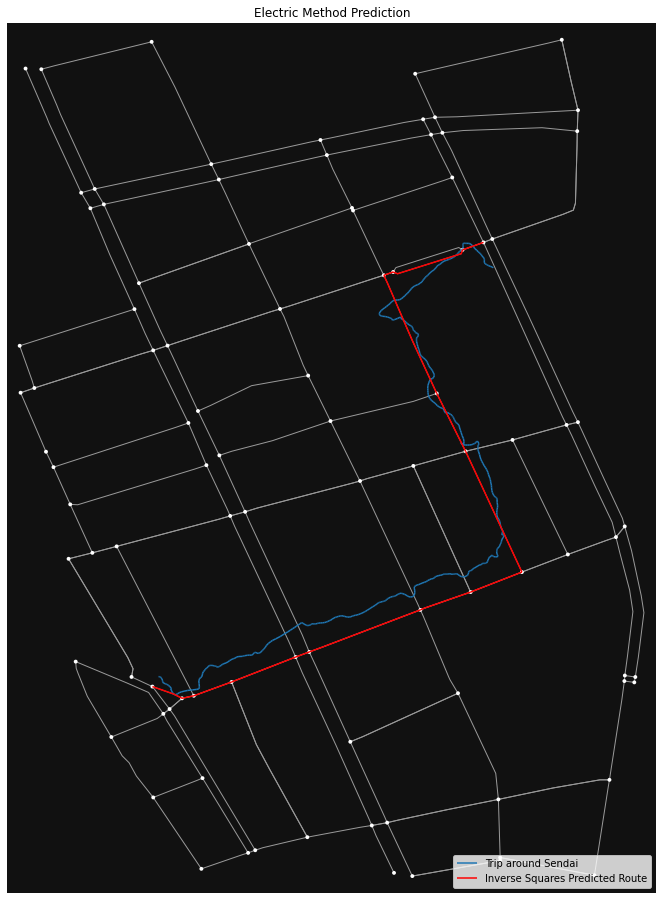

In [18]:
mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim3_results, fs = (16,16))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Inverse Squares Predicted Route'], loc = 'lower right')
plt.gca().set_title('Electric Method Prediction')

Text(0.5, 1.0, 'Wasserstein Prediction')

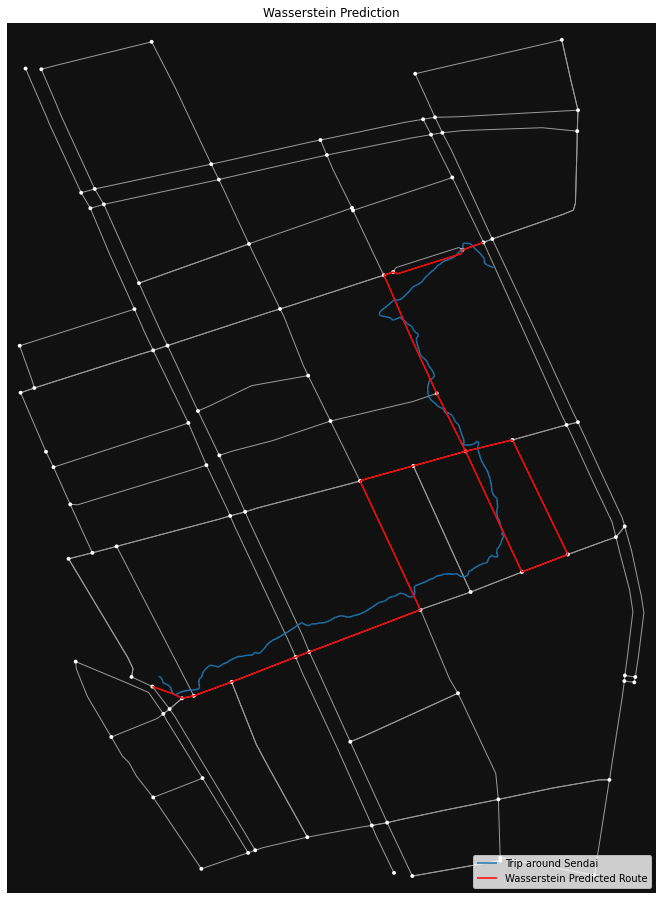

In [19]:

mm_utils.plot(network = smallnetwork, input_data = tripdata_edges, results = sim4_results, fs = (16,16))
plt.gca().legend(handles=[plt.gca().collections[2],plt.gca().collections[3]],labels=['Trip around Sendai','Wasserstein Predicted Route'], loc = 'lower right')
plt.gca().set_title('Wasserstein Prediction')